In [1]:
%cd -q data/actr_reco

In [97]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np

In [4]:
with open("users.txt", "r") as f:
    users = f.readlines()

In [22]:
hist = []
for user in tqdm.tqdm(users):
    user = user.strip()
    ret = !wc -l user_split/listening_events_2019_{user}.tsv
    lc, _ = ret[0].split(" ")
    hist.append(int(lc))
len(hist), sum(hist)

100%|██████████| 18316/18316 [16:21<00:00, 18.66it/s]


(18316, 135142263)

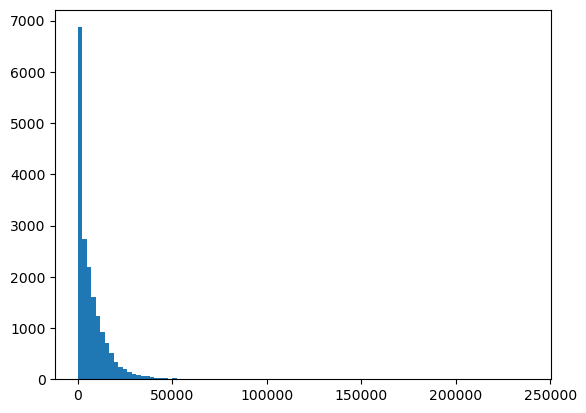

In [38]:
plt.hist(hist, bins=100)
plt.show()

In [69]:
subset = [x for x in hist if x < 30_000 and x >= 1_000]
len(subset)

12977

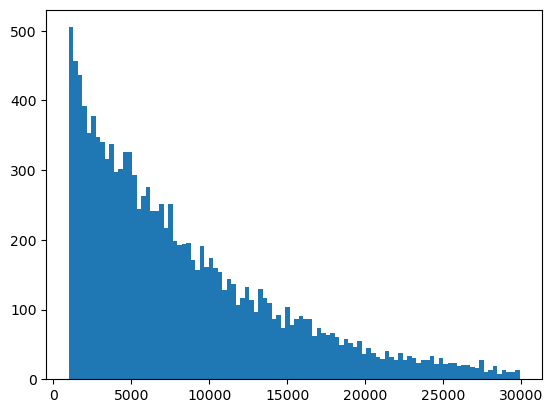

In [67]:
plt.hist(subset, bins=100)
plt.show()

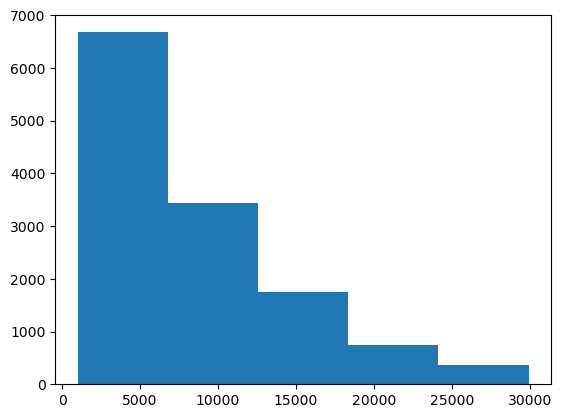

In [51]:
plt.hist(subset, bins=5)
plt.show()

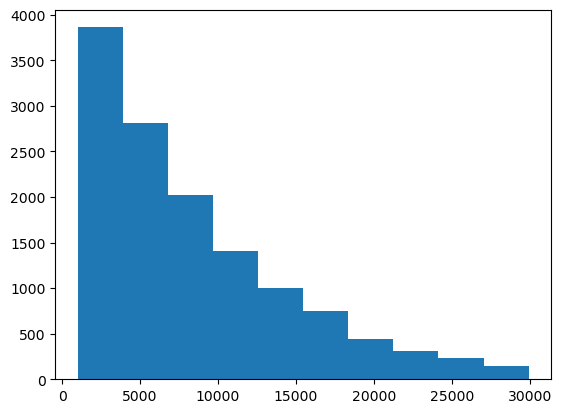

In [52]:
plt.hist(subset, bins=10)
plt.show()

In [53]:
plt.hist(subset, bins=10)

(array([3862., 2812., 2021., 1412., 1002.,  745.,  440.,  309.,  233.,
         141.]),
 array([ 1001. ,  3892.2,  6783.4,  9674.6, 12565.8, 15457. , 18348.2,
        21239.4, 24130.6, 27021.8, 29913. ]),
 <BarContainer object of 10 artists>)

# Stratification

In [269]:
def stratification_numbers(data, min_value, max_value, bins, num_samples):
    subset = [x for x in data if x >= min_value and x < max_value]
    percentage = num_samples / len(subset)
    bin_size = int((max_value-min_value)/bins)
    
    num_per_bin = []
    old_boundary = min_value
    for new_boundary in range(min_value+bin_size, max_value+1, bin_size):
        data_in_bin = [x for x in subset if x >= old_boundary and x < new_boundary]
        num_per_bin.append(len(data_in_bin))
        old_boundary = new_boundary
    assert sum(num_per_bin) == len(subset)
    
    samples_per_bin = np.array(num_per_bin)*percentage
    floor_samples_per_bin = np.floor(samples_per_bin)
    error = int(round(sum(samples_per_bin) - sum(floor_samples_per_bin)))
    if error == 0:
        assert sum(floor_samples_per_bin) == num_samples
        return floor_samples_per_bin
    
    remainders = np.remainder(samples_per_bin, 1)
    to_adjust = np.argsort(remainders)[::-1][:error]
    for ta in to_adjust:
        floor_samples_per_bin[ta] += 1
    
    assert sum(floor_samples_per_bin) == num_samples
    return floor_samples_per_bin

In [196]:
samples_per_bin = stratification_numbers(hist, 1_000, 30_000, 10, num_samples=100)
samples_per_bin, sum(samples_per_bin)

(array([30., 22., 16., 11.,  8.,  5.,  3.,  2.,  2.,  1.]), 100.0)

In [198]:
stratification_numbers(hist, 1_000, 30_000, 10, 2)

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

# Iterative Stratified Sampling

In [201]:
test_hist = hist[len(test_users):]
assert len(test_hist) == len(test_users)

In [215]:
test_user_interaction = list(zip(test_users, test_hist))
test_user_interaction[:2]

[('61740\n', 7678), ('37608\n', 10920)]

In [216]:
!wc -l user_split/listening_events_2019_61740.tsv

7678 user_split/listening_events_2019_61740.tsv


In [232]:
def get_bin_boundaries_from_config(bin_config=None):
    if not bin_config:
        bin_config = {"min_value": 1_000, "max_value": 30_000, "bins": 10}
    bin_size = int((bin_config["max_value"]-bin_config["min_value"])/bin_config["bins"])
    return list(range(bin_config["min_value"], bin_config["max_value"]+1, bin_size))

In [236]:
def check_in_bin(item_value, target_bin, bin_config=None):
    bin_boundaries = get_bin_boundaries_from_config()
    return item_value >= bin_boundaries[target_bin] and item_value < bin_boundaries[target_bin+1]

assert check_in_bin(2400, 0)
assert not check_in_bin(5000, 0)
assert check_in_bin(29_000, 9)

In [238]:
def get_next_for_bin(user_interactions, target_bin):
    iterlist = user_interactions.copy()
    for ui in user_interactions:
        if check_in_bin(ui[1], target_bin):
            iterlist.remove(ui)
            return ui[0], iterlist
    raise StopIteration("No remaing items for bin.")

In [218]:
def list_index_difference(list1, list2):
    changed_indices = []
    for index, (first, second) in enumerate(zip(list1, list2)):
        if first != second:
            changed_indices.append(index)
    return changed_indices

assert list_index_difference([0,1], [0,0]) == [1]

In [304]:
def iterative_sampling(user_interactions, max_size=1000, num_bins=10):
    iterlist = user_interactions.copy()
    bins = num_bins*[0]
    
    sampled_list = []
    
    mult_index_changes = []
    
    for i in tqdm.tqdm(range(1, max_size+1)):
        updated_bins = stratification_numbers(hist, 1_000, 30_000, 10, num_samples=i)
        changed_indices = list_index_difference(bins, updated_bins)
        if len(changed_indices) != 1:
            mult_index_changes.append(i)
#             print(f"Multi-index change at pos {i}: {changed_indices} (old: {bins} vs new: {updated_bins}")
        target_bin = changed_indices[0]  # empirically increase the first change index, assuming items are in descending order
        bins[target_bin] += 1
        
        item, iterlist = get_next_for_bin(iterlist, target_bin)
        sampled_list.append(item)
    
    print(len(mult_index_changes))
    print(mult_index_changes[-3:])
    print(bins)
    return sampled_list

In [308]:
sampled_list = iterative_sampling(test_user_interaction, 150)
len(sampled_list)

100%|██████████| 300/300 [00:02<00:00, 110.74it/s]

52
[280, 281, 300]
[90, 65, 47, 32, 23, 17, 10, 7, 6, 3]


300

In [310]:
# overlap
len(set(test_users[:300]).intersection(set(sampled_list[:150])))

210

In [311]:
with open("sampled.txt", "w") as f:
    f.write("".join(sampled_list))

In [314]:
!head sampled.txt

103807
73151
61740
37608
30387
90919
35812
28952
94584
95562


In [315]:
!wc -l sampled.txt

300 sampled.txt
